# 08. PyTorch Paper Replicating

The goal of machine learning research paper replicating is: turn a ML research paper into usable code.

In this notebook, we're going to be replicating the Vision Transformer (ViT) with PyTorch

## 0. Get setup

Let's import code we've previously written + required libraries.

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.2.1+cu121
torchvision version: 0.17.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 31.39 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get Data


In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

In [7]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Create image size
IMG_SIZE = 224 # comes from Table 3 of the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
                                        transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                        transforms.ToTensor(),
])


print(f"Manually created transforms: {manual_transforms}")




Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [8]:
# Create a batch size of 32 (the paper uses 4096 but this may be too big for our hardware)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)


In [9]:
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [10]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([3, 224, 224]), tensor(1))

Text(0.5, 1.0, 'pizza')

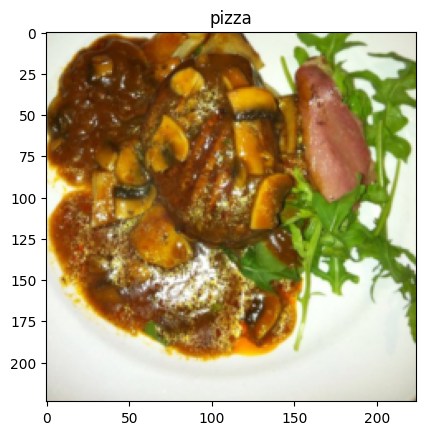

In [11]:
# Plot the image with matplotlib
import matplotlib.pyplot as plt
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[0])

## 3. Replicating ViT: Overview

Looking at a whole machine learning research paper can be imtimidating.

So in order to make it more understandable, we can break it into smaller pieces:

* **Inputs** - What goes into the model? (in our case, image tensors)
* **Outputs** * - What comes out of the model/layer/block (in our case, we want the model to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention)
* **Blocks** - A collection of Layers.
* **Model** - A collection of blocks

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output

What's the input shape?: (224, 224, 3) -> single image -> (H, W, C)

What's the output shape?

In [12]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size ** 2)
number_of_patches

196

In [13]:
# Input Shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shaoe
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image): {embedding_layer_output_shape}")


Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image): (196, 768)


(-0.5, 223.5, 223.5, -0.5)

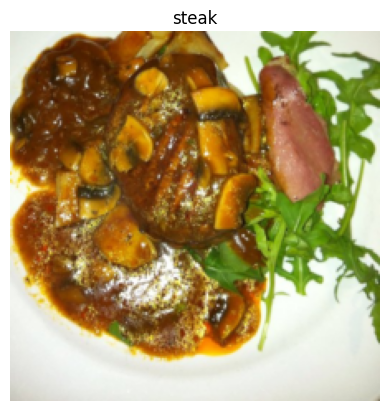

In [14]:
# 4.2 Turning a single image into patches
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [15]:
image.shape

torch.Size([3, 224, 224])

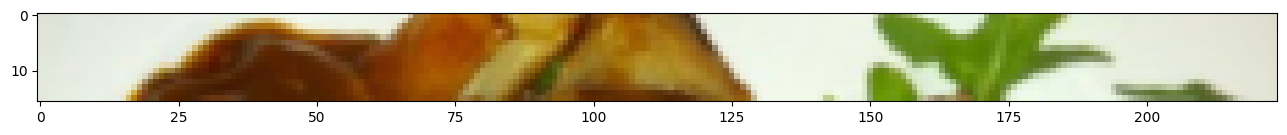

In [16]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # convert image to color channels last (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

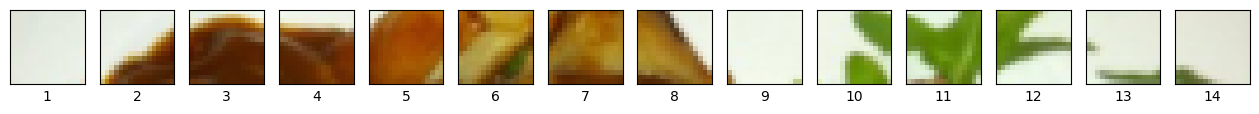

In [17]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size // patch_size
num_patches
assert img_size % patch_size == 0 # Image size must be divisible by patch size

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=num_patches,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch: patch + patch_size, :])
  axs[i].set_xlabel(i + 1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

In [18]:
# # Setup code to plot whole image as patches
# # Create a series of subplots
# fig, axs = plt.subplots(nrows=num_patches,
#                         ncols=num_patches,
#                         sharex=True,
#                         sharey=True,
#                         figsize=(patch_size, patch_size))

# # Iterate through number of patches in the top row
# for i, patch_height in enumerate(range(0, img_size, patch_size)):
#   for j, patch_width in enumerate(range(0, img_size, patch_size)):
#     axs[i][j].imshow(image_permuted[patch_height:patch_height + patch_size, patch_width: patch_width + patch_size, :])
#     axs[i][j].set_xlabel(i + 1)
#     axs[i][j].set_xticks([])
#     axs[i][j].set_yticks([])

In [19]:
### 4.3 Creating image patches and turning them into patch embeddings
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)

from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768, # Size of D
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0
                   )
conv2d


Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [20]:
# Pass the image through the convolutional layer

image_out_of_cov = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, clolor_channels, height, weight)
print(image_out_of_cov.shape)

torch.Size([1, 768, 14, 14])


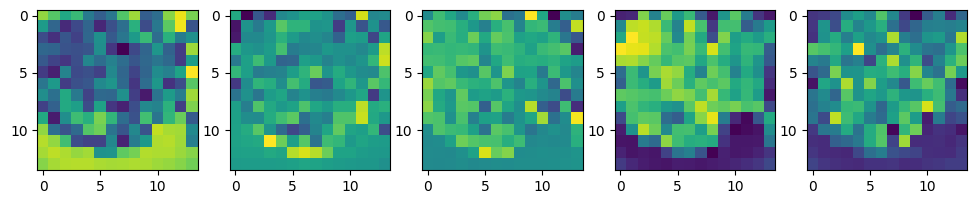

In [21]:
# plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 768), k = 5)
random_indexes

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

# plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_cov[:, idx, :, :]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())

In [22]:
single_feature_map = image_out_of_cov[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.7270, -0.7102, -0.2885, -0.4302, -0.2607, -0.2684, -0.2063,
           -0.1025, -0.7617, -0.6316, -0.4889, -0.5726, -0.6413, -0.6379],
          [-0.8838, -0.1634, -0.2533, -0.1368, -0.1366, -0.3097, -0.2327,
           -0.1024, -0.5000, -0.6098, -0.3366, -0.3238, -0.4796, -0.6514],
          [-0.5515, -0.2085, -0.1849, -0.1786, -0.1917, -0.3563, -0.3232,
           -0.3879, -0.1708, -0.5597, -0.4003, -0.4512, -0.5946, -0.2055],
          [-0.1693, -0.1002, -0.1940, -0.2174, -0.3353, -0.3594, -0.2128,
           -0.2836, -0.2199, -0.2470, -0.5050, -0.2805, -0.2446, -0.2996],
          [-0.2860, -0.1914, -0.2278, -0.2958, -0.2870, -0.4064, -0.3497,
           -0.4030, -0.2482, -0.3037, -0.5824, -0.3975, -0.2822, -0.3681],
          [-0.9518, -0.3358, -0.2841, -0.1903, -0.2710, -0.1719, -0.3347,
           -0.2795, -0.3183, -0.2903, -0.3631, -0.4132, -0.1748, -0.6714],
          [-0.7238, -0.2286, -0.3027, -0.3104, -0.2757, -0.2813, -0.2448,
           -0.4840, -0.3225, -0.

In [23]:
### 4.4 Flattening the patch embedding with torch.nn.Flatten()
# Right now we've got a series of covn feature maps - flatten into a sequence

image_out_of_cov.shape # [1, 768, 14, 14] - [1, 196, 768]

torch.Size([1, 768, 14, 14])

In [24]:
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)
image_out_of_cov_flattened = flatten_layer(image_out_of_cov)

In [25]:
image_out_of_cov_flattened.permute(0, 2, 1).shape # [batch_size, number of patchs, D]

torch.Size([1, 196, 768])

In [26]:
image_out_of_cov_flattened_permuted = image_out_of_cov_flattened.permute(0, 2, 1)

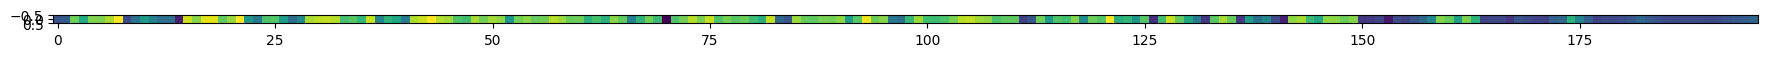

In [27]:
plt.figure(figsize=(22, 22))
plt.imshow(image_out_of_cov_flattened_permuted[:,:,0].detach().numpy())

In [28]:
### 4.5. Turing the ViT patch embedding layer into a PyTorch Model

class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels: int=3,
               patch_size: int=16,
               embedding_dim: int=768):
    super().__init__()

    self.patch_size = patch_size

    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)


    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)


  def forward(self, x):
    image_resolution = x.shape[-1]

    assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by patch size, image shape:{image_resolution}, patch_size: {self.patch_size}"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    return x_flattened.permute(0, 2, 1)





In [29]:
set_seeds()

In [30]:
patchify = PatchEmbedding(patch_size=16)

patch_embedded_image = patchify(image.unsqueeze(0))
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [31]:
### 4.6 Creating the class token embedding
# Prepent a learnable class token to the start of the patch embedding
patch_embedded_image

tensor([[[-0.9501,  0.2746, -0.2796,  ...,  0.7271, -0.4155,  0.3273],
         [-0.8218,  0.1080,  0.3023,  ...,  0.2673, -0.4529,  0.2968],
         [-0.1185,  0.1175, -0.0112,  ...,  0.1839, -0.4812,  0.1356],
         ...,
         [-0.9158,  0.2485, -0.2281,  ...,  0.6924, -0.4388,  0.3248],
         [-0.8865,  0.2362, -0.2258,  ...,  0.6758, -0.4303,  0.3164],
         [-0.8072,  0.2336, -0.2121,  ...,  0.6524, -0.4243,  0.3030]]],
       grad_fn=<PermuteBackward0>)

In [32]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [33]:
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token

Parameter containing:
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 

In [34]:
class_token.shape

torch.Size([1, 1, 768])

In [35]:
patch_embedded_image

tensor([[[-0.9501,  0.2746, -0.2796,  ...,  0.7271, -0.4155,  0.3273],
         [-0.8218,  0.1080,  0.3023,  ...,  0.2673, -0.4529,  0.2968],
         [-0.1185,  0.1175, -0.0112,  ...,  0.1839, -0.4812,  0.1356],
         ...,
         [-0.9158,  0.2485, -0.2281,  ...,  0.6924, -0.4388,  0.3248],
         [-0.8865,  0.2362, -0.2258,  ...,  0.6758, -0.4303,  0.3164],
         [-0.8072,  0.2336, -0.2121,  ...,  0.6524, -0.4243,  0.3030]]],
       grad_fn=<PermuteBackward0>)

In [36]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)

In [37]:
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [38]:
patch_embedded_image_with_class_embedding

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.9501,  0.2746, -0.2796,  ...,  0.7271, -0.4155,  0.3273],
         [-0.8218,  0.1080,  0.3023,  ...,  0.2673, -0.4529,  0.2968],
         ...,
         [-0.9158,  0.2485, -0.2281,  ...,  0.6924, -0.4388,  0.3248],
         [-0.8865,  0.2362, -0.2258,  ...,  0.6758, -0.4303,  0.3164],
         [-0.8072,  0.2336, -0.2121,  ...,  0.6524, -0.4243,  0.3030]]],
       grad_fn=<CatBackward0>)

In [39]:
### 4.7 Creating the position embedding
# Create a series of 1D learnable position embeddings and add them to the sequence of patch embeddings



patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.9501,  0.2746, -0.2796,  ...,  0.7271, -0.4155,  0.3273],
          [-0.8218,  0.1080,  0.3023,  ...,  0.2673, -0.4529,  0.2968],
          ...,
          [-0.9158,  0.2485, -0.2281,  ...,  0.6924, -0.4388,  0.3248],
          [-0.8865,  0.2362, -0.2258,  ...,  0.6758, -0.4303,  0.3164],
          [-0.8072,  0.2336, -0.2121,  ...,  0.6524, -0.4243,  0.3030]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [40]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size ** 2)
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches + 1,
                                             embedding_dimension),
                                  requires_grad=True)
position_embedding

Parameter containing:
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True)

In [41]:
position_embedding.shape

torch.Size([1, 197, 768])

In [42]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.0499, 1.2746, 0.7204,  ..., 1.7271, 0.5845, 1.3273],
         [0.1782, 1.1080, 1.3023,  ..., 1.2673, 0.5471, 1.2968],
         ...,
         [0.0842, 1.2485, 0.7719,  ..., 1.6924, 0.5612, 1.3248],
         [0.1135, 1.2362, 0.7742,  ..., 1.6758, 0.5697, 1.3164],
         [0.1928, 1.2336, 0.7879,  ..., 1.6524, 0.5757, 1.3030]]],
       grad_fn=<AddBackward0>)

In [43]:
### 4.8 Putting it all together: from image to embedding
# We've written code to turn an image in a flattened sequence of patch embeddings
# Now let's it all in one cell

patch_size = 16
height, width = image.shape[1], image.shape[2]
x = image.unsqueeze(0)
patch_embedding_layer = PatchEmbedding()
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)

# Create position embedding
number_of_patches = int(height*width) // patch_size**2
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
patch_and_position_embedding = patch_embedding_class_token + position_embedding
patch_and_position_embedding.shape


Patch embedding shape: torch.Size([1, 196, 768])


torch.Size([1, 197, 768])

In [44]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.6882, 0.8017, 0.1990,  ..., 1.8558, 1.2832, 0.9328],
         [1.6177, 0.9858, 0.2284,  ..., 1.3769, 1.7209, 1.2925],
         ...,
         [1.6681, 0.8086, 0.1961,  ..., 1.8082, 1.3225, 0.9800],
         [1.6536, 0.8079, 0.2174,  ..., 1.7779, 1.3132, 0.9760],
         [1.6476, 0.8308, 0.2499,  ..., 1.7536, 1.3052, 0.9635]]],
       grad_fn=<AddBackward0>)

# Equation 2 Multihead self-Attention Overview

In [45]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """
    Create a multi-head self-attention block ("MAS block" for short)
  """
  def __init__(self,
               embedding_dim: int=768, # Hidden size D (embedding dimension) from Tabel 1 for ViT-Base
               num_heads: int=12, # Head from Table 1
               attn_dropout=0):
    super().__init__()


    # Create the norm Layer
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create Multihead attention (MSA) layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                         key=x,
                                         value=x,
                                         need_weights=False)
    return attn_output



In [46]:
# Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock()
# Pass the patch and position image embedding sequence through MSA block
patched_image_through_mas_block = multihead_self_attention_block(patch_and_position_embedding)
patched_image_through_mas_block

tensor([[[ 0.2218,  0.1068, -0.1423,  ..., -0.0165, -0.8386, -0.4213],
         [ 0.2136,  0.1085, -0.1585,  ..., -0.0203, -0.8319, -0.4193],
         [ 0.2149,  0.1069, -0.1553,  ..., -0.0215, -0.8315, -0.4240],
         ...,
         [ 0.2136,  0.1083, -0.1585,  ..., -0.0206, -0.8319, -0.4194],
         [ 0.2137,  0.1082, -0.1586,  ..., -0.0206, -0.8319, -0.4194],
         [ 0.2137,  0.1084, -0.1591,  ..., -0.0207, -0.8322, -0.4196]]],
       grad_fn=<TransposeBackward0>)

In [47]:
patched_image_through_mas_block.shape

torch.Size([1, 197, 768])

# 6. Equation 3: Multilayer Perceptron

In [48]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim: int=768,
               mlp_size: int=3072,
               dropout: int=0.1
               ):
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)

    return x

In [49]:
mlp_block = MLPBlock()
patched_image_through_mlp_block = mlp_block(patched_image_through_mas_block)
patched_image_through_mlp_block.shape

torch.Size([1, 197, 768])

In [50]:
patched_image_through_mlp_block

tensor([[[ 0.0161, -0.3531,  0.0923,  ..., -0.1973,  0.2986, -0.1302],
         [ 0.0453, -0.1682,  0.1496,  ..., -0.2590,  0.2741, -0.1780],
         [-0.1190, -0.2883,  0.1210,  ..., -0.0676,  0.2528, -0.0250],
         ...,
         [ 0.0077, -0.1945, -0.0342,  ..., -0.1255,  0.2620, -0.2155],
         [-0.2068, -0.3060,  0.0189,  ..., -0.1933,  0.2691, -0.1700],
         [ 0.0585, -0.2188,  0.0801,  ..., -0.0362,  0.2022,  0.0206]]],
       grad_fn=<MulBackward0>)

# 7. Create the Transformer Encoder

In [51]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim: int=768, # Hidden size D from table 1, 768 for ViT-Base
               num_heads: int=12,
               mlp_size: int=3072,
               mlp_dropout: float=0.1,
               attn_dropout: int=0):
    super().__init__()

    # Create MSA block
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    # Create MLP block
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x

    return x


In [52]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()


summary(model=transformer_encoder_block,
        input_size=(1,197,768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [53]:
### 7.2 Create a Transformer Encoder layer with in-built Pytorch Layer
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True,
                                                             )
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [54]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1,197,768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [55]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [56]:
vit = ViT()

In [57]:
set_seeds()
random_ima